# Moment Forecasting Example

## Loading Moment Model

In [ ]:
import os
import sys
import numpy as np

src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from samay.model import MomentModel
from samay.dataset import MomentDataset

repo = "AutonLab/MOMENT-1-large"
config = {
    "task_name": "forecasting",
    "forecast_horizon": 192,
    "head_dropout": 0.1,
    "weight_decay": 0,
    "freeze_encoder": True,  # Freeze the patch embedding layer
    "freeze_embedder": True,  # Freeze the transformer encoder
    "freeze_head": False,  # The linear forecasting head must be trained
}
mmt = MomentModel(config=config, repo=repo)

## Finetune Moment Model on the ETT dataset

In [ ]:
train_dataset = MomentDataset(
    name="ett",
    datetime_col="date",
    path="/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv",
    mode="train",
    horizon=192,
)
val_dataset = MomentDataset(
    name="ett",
    datetime_col="date",
    path="/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv",
    mode="test",
    horizon=192,
)
finetuned_model = mmt.finetune(train_dataset)

/nethome/sli999/anaconda3/envs/torch/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 0: Train loss: 0.620
Epoch 1: Train loss: 0.541


## Test the Finetuned Model

In [3]:
avg_loss, trues, preds, histories = mmt.evaluate(val_dataset)
print("Validation loss:", avg_loss)

Validation loss: 0.5464385730879647


## Visualization of the evaluation

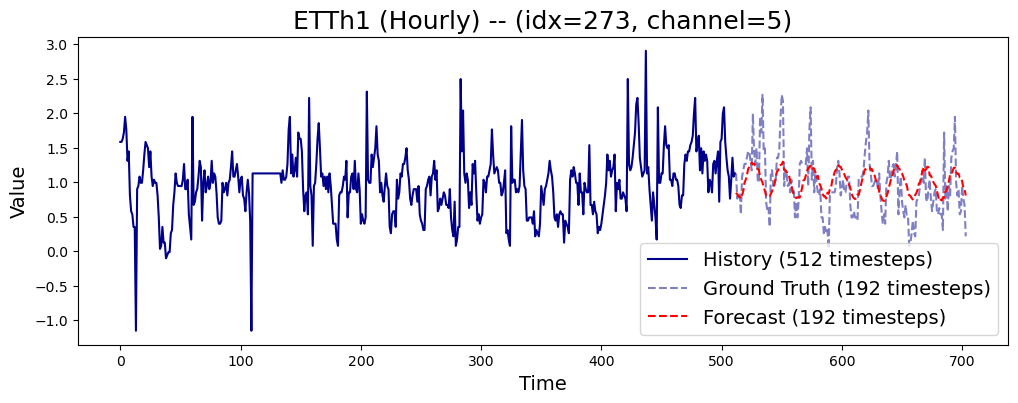

In [ ]:
import matplotlib.pyplot as plt

# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()